# Analysis of time-reversed model for oscillatory particle attraction
Tim Tyree<br>
12.13.2021

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from lib import *
from scipy.signal import savgol_filter
import dask.bag as db
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    
seed=42
np.random.seed(seed)

In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

For the given phase, $\phi_0$, and for $t'=t_f-t$, the time-reversed problem is

$$
\frac{d\bar R}{dt'} = \frac{2a}{\bar R}\cos(\phi'-\omega t')
$$


We intend to study numerically the mean-squared range (MSR) versus the time leading up to annihilation in the presence of white-noise.  Our stochastic model is

$$
d\bar R = -\frac{2a}{\bar R}\cos(\omega t)dt + \sqrt{4D}dW
$$


# define module

In [3]:
# def gener_positions_oscillatory_reversed(
#     num_pairs=150, #number of independent pairs of particles
#     a=8.5, #cm^2/s known attraction coefficient 
#     D=0.3, #cm^2/s known diffusion coefficient
#     Dt=1e-5, #s
#     initial_phase_orientation=0.,#radians
#     period_of_oscillation=90.,#ms
#     rstart=1e-4,
#     rend=4, #cm
#     tmax=1,
#     printing=False,print_every=50000,
#     mode='oscillatory',
#     use_early_stopping=True,
#     **kwargs
#     ):
#     '''
#     Example Usage:
#     dict_out,positions_out=gener_positions_oscillatory_reversed(a=a,D=D,initial_phase_orientation=0.,printing=True)
#     '''
#     dont_break=True
#     #initialize particles locations as being at the same locations
#     t=0
#     x1=0
#     x2=np.sqrt(rstart)
#     y1=0
#     y2=np.sqrt(rstart)
#     zero_values=np.zeros(num_pairs)

#     x1_values=zero_values.copy()+x1
#     x2_values=zero_values.copy()+x2
#     y1_values=zero_values.copy()+y1
#     y2_values=zero_values.copy()+y2

#     stepscale = np.sqrt(2 * D * Dt)
#     impulse_prefactor = a * Dt

#     #tmax=1#10#0.1#1 #seconds
#     num_steps=np.int64(np.around(tmax/Dt))

#     position_array=np.zeros(shape=(num_steps,4,num_pairs))+np.nan
#     mean_array=np.zeros(shape=(num_steps,3))
#     std_array=np.zeros(shape=(num_steps,3))

#     #add support for still_running
#     boo_still_running=zero_values==zero_values

#     #compute the distance between each pair of particles
#     dx_values=(x2_values-x1_values)
#     dy_values=(y2_values-y1_values)
#     Rsq_values=dx_values*dx_values+dy_values*dy_values
#     omega=((1e-3*period_of_oscillation/(2*np.pi))**-1)
#     ##enforces the alignment boundary condition. smart, but might be messing up the oscillations
#     time_constant=initial_phase_orientation/omega
#     #time_constant=0.
#     if printing:
#         print(f"running simulation for {num_steps} steps...")
#     start=time.time()
#     step_num=0
#     while dont_break and (step_num < num_steps):
#         t=step_num*Dt + time_constant
#         #compute the attractive step between all pairs
#         f_values=impulse_prefactor/Rsq_values
#         F1x=f_values*dx_values
#         F1y=f_values*dy_values
#         if mode=='oscillatory':
#             F1x*=np.cos(omega*t)
#             F1y*=np.cos(omega*t)

#         #compute the diffusive step between all pairs
#         dxW1_values=stepscale*np.random.normal(size=num_pairs)
#         dxW2_values=stepscale*np.random.normal(size=num_pairs)
#         dyW1_values=stepscale*np.random.normal(size=num_pairs)
#         dyW2_values=stepscale*np.random.normal(size=num_pairs)

#         #the mean distance between all pairs of particles
#         R_values=np.sqrt(Rsq_values)
#         mean_R=np.mean(R_values)
#         std_R=np.std(R_values)

#         #the mean magnitude of the diffusive step
#         diffusive_step_values=0.5*np.sqrt(dxW1_values**2+dyW1_values**2)+0.5*np.sqrt(dxW2_values**2+dyW2_values**2)
#         mean_diffusive_step=np.mean(diffusive_step_values)
#         std_diffusive_step=np.std(diffusive_step_values)

#         #the mean magnitude of the attractive step
#         attractive_step_values=np.sqrt(F1x**2+F1y**2)
#         mean_attractive_step=np.mean(attractive_step_values)
#         std_attractive_step=np.std(attractive_step_values)
#         if printing:
#             if (step_num+1) % print_every == 0:
#                 relative_percent=100*mean_diffusive_step/mean_attractive_step
#                 print(f"simulation {100*(step_num+1)/num_steps:.0f}% completed: R={mean_R:.4f}+/-{1.96*std_R:.4f}, diffusion/attraction is {relative_percent:.2f}%")
#                 # print(f"the mean range is {mean_R:.4f} cm")
#                 # print(f"the mean diffusive step was {100*mean_diffusive_step/mean_attractive_step:.2f}% larger than the mean attractive step")

#         #compute the net change in position (with signs chosed s.t. repulsive at zero phase)
# #         x1step_values=F1x+dxW1_values
# #         y1step_values=F1y+dyW1_values
# #         x2step_values=-F1x+dxW2_values
# #         y2step_values=-F1y+dyW2_values
#         x1step_values=-F1x+dxW1_values
#         y1step_values=-F1y+dyW1_values
#         x2step_values=F1x+dxW2_values
#         y2step_values=F1y+dyW2_values

#         #identify any particles that didn't get within the threshold distance
#         #compute the distance between each pair of particles
#         dx_values=(x2_values-x1_values)
#         dy_values=(y2_values-y1_values)
#         Rsq_values=dx_values**2+dy_values**2

#         #update particle locations if they are still running
#         x1_values[boo_still_running]=x1_values[boo_still_running]+x1step_values[boo_still_running]
#         y1_values[boo_still_running]=y1_values[boo_still_running]+y1step_values[boo_still_running]
#         x2_values[boo_still_running]=x2_values[boo_still_running]+x2step_values[boo_still_running]
#         y2_values[boo_still_running]=y2_values[boo_still_running]+y2step_values[boo_still_running]
#         #DONE: verified the mean distance between particles got smaller    
#         # if (step_count+1) % save_every == 0:
#         #save particle locations to a numpy array with the correct number of positions
#         # x1,y1,x2,y2
#         position_array[step_num,0,boo_still_running]=x1_values[boo_still_running]
#         position_array[step_num,1,boo_still_running]=y1_values[boo_still_running]
#         position_array[step_num,2,boo_still_running]=x2_values[boo_still_running]
#         position_array[step_num,3,boo_still_running]=y2_values[boo_still_running]
#         mean_array[step_num,0]=mean_R
#         mean_array[step_num,1]=mean_diffusive_step
#         mean_array[step_num,2]=mean_attractive_step
#         #save results for quick plotting
#         std_array[step_num,0]=std_R
#         std_array[step_num,1]=std_diffusive_step
#         std_array[step_num,2]=std_attractive_step

#     #         #identify any particles that didn't get within the threshold distance
#     #         #compute the distance between each pair of particles
#     #         dx_values=(x2_values-x1_values)
#     #         dy_values=(y2_values-y1_values)
#     #         Rsq_values=dx_values*dx_values+dy_values*dy_values
#         R_values=np.sqrt(Rsq_values)
#         boo_still_running=boo_still_running&(R_values<rend)
        
#         step_num+=1
#         if use_early_stopping and not boo_still_running.any():
#             dont_break=False
#     if printing:
#         print(f"simulation complete!\nTotal run time: {time.time()-start:.4f} seconds")
#         print(f"the number of particles that didn't finished is {sum(boo_still_running)} out of {boo_still_running.shape[0]}.")

#     dict_out={
#         #         "Gamma_max":np.float32(Gamma_max),
#         #         "Gamma_values":Gamma_values.astype('float32'),
#         "Rsq_values":Rsq_values.astype('float32'),
#         "mean_array":mean_array.astype('float32'),
#         "std_array":std_array.astype('float32')
#     }
#     if printing:
#         print(*dict_out)
#         #print_dict(dict_out)
#     return dict_out,position_array#positions_out

In [4]:
# def visualize_model_oscillatory_reversed(ax=None,
#     a=1.6,#8.5,
#     D=0.6,#0.3,
#     initial_phase_orientation=np.pi,#0#np.pi/2,#-np.pi/2,
#     period_of_oscillation=45.,
#     num_pairs=1000,
#     rstart=1e-4,#1.5,
#     Dt=1e-5,
#     xmin=0,
#     xmax=0.1,
#     ymin=0,
#     ymax=0.6,
#     alpha=0.7,
#     show_inputted_a=True,show_title=True,show_legend=True,use_xylim=True,    
#     show_label_black_dotted=False,
#     printing=True,
#     plotting=True,c='C3',label=r"Simulation",**kwargs):
#     """generate MSR using the time-reversed oscillatory model. estimated run time is 15 seconds for 100 statistically independent trials.
#     Example Usage:
#     dict_fit=visualize_model_oscillatory_reversed(a=1.6,D=0.3,c='C0',label='Fenton-Karma')
#     dict_fit=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
#     plt.show()
#     """
#     dict_out,position_array = gener_positions_oscillatory_reversed(
#                 a=a, D=D, printing=False,num_pairs=num_pairs,period_of_oscillation=period_of_oscillation,initial_phase_orientation=initial_phase_orientation,**kwargs)
#     positions_out=position_array
#     if printing:
#         print(*dict_out)
#         print(f"positions_out.shape={positions_out.shape}")

#     title=f"a={a:.1f}, D={D:.1f}, T={period_of_oscillation:.1f}, "+r"$\phi_f$"+f"={initial_phase_orientation:.4f}, "+r"R$_f$"+f"={rstart:.0e}, "+r" N$_{trials}$"+f"={num_pairs}\n"
    
#     #compute the distance between each pair of particles after aligning by annihilation (unshifted)
#     x1_values=positions_out[:,0]
#     y1_values=positions_out[:,1]
#     x2_values=positions_out[:,2]
#     y2_values=positions_out[:,3]
#     dx_values=(x2_values-x1_values)
#     dy_values=(y2_values-y1_values)
#     Rsq_values=dx_values**2+dy_values**2
#     #compute the ensemble averaged values
#     MSR_values=np.mean(Rsq_values,axis=1)
#     aligned_coordinates_values=np.mean(positions_out,axis=-1)
#     # maxt=Dt*MSR_values.shape[0]
#     t_values=np.arange(MSR_values.shape[0])*Dt
#     boo=~(np.isnan(t_values)|np.isnan(MSR_values))
#     dict_fit=compute_95CI_ols(t_values[boo],MSR_values[boo])
#     if printing:
#         print_dict(dict_fit)    
#         print(f"num_samples={positions_out.shape[-1]}")
#         print(f"num_timepoints={t_values.shape[0]}")
#         print(f"ahat = {dict_fit['m']/4:.4f}+/-{dict_fit['Delta_m']/4:.4f}")
    
#         if ax is None:
#             ax=plt.gca()
#         xv=np.linspace(xmin,xmax,100)
#         if show_inputted_a:
#             if show_label_black_dotted:
#                 ax.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
#             else:
#                 ax.plot(xv,4*a*xv,'k--')#,label=r'$4a(t_f-t)$')
#         if use_xylim:
#             ax.set_xlim([xmin,xmax])
#             ax.set_ylim([ymin,ymax])
#         ax.plot(t_values,MSR_values,c=c,label=label,alpha=alpha)
#         if show_title:
#             plt.title(title,fontsize=16)
#         if show_legend:
#             plt.legend(fontsize=16)
#         #plt.plot(t_values,t_values*0.,'--',c='gray',alpha=0.5)
#     #record
#     dict_fit['title']=title
#     dict_fit['tdeath']=t_values
#     dict_fit['MSR']=MSR_values
#     return dict_fit

# import data from cache

In [5]:
# # # dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# # dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma')
# # dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
# # format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# # plt.xlim([0,1])
# # plt.ylim([0,3])
# # plt.show()
# print(f"{1e-3:.0e}")

In [6]:
#estimate a_sr expected for this value with a sliding window
msr_dir_lr=f'{nb_dir}/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083
msr_dir_fk=f'{nb_dir}/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
msr_dir_fk

'/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'

In [7]:
#estimate a_sr expected for this value with a sliding window
msr_dir_lr=f'{nb_dir}/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083
msr_dir_fk=f'{nb_dir}/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms
df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

In [8]:
tmax=300#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=8#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
print('')
# tmax=8#ms #gives a nice value
tmax=90#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

tmax=8#ms #gives a nice value
# tmax=90#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.604153+/-0.040173 cm^2/s, tmax=300
a_hat_FK = 7.392251+/-0.601845 cm^2/s, tmax=8

a_hat_LR = 2.245111+/-0.224026 cm^2/s, tmax=90
a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8


In [9]:
# a_osc_LR=8.5/4
# a_osc_FK=1.6
# D_osc_LR=3.#1.2
# D_osc_FK=1.6#.8
# a_osc_LR=8.5
# a_osc_FK=1.6
# D_osc_LR=0.6
# D_osc_FK=0.3
#worked pretty well
# a_osc_LR=8.5/2
# a_osc_FK=1.6
# D_osc_LR=1.2
# D_osc_FK=.9#.8
# #a=D test cases
# a_osc_LR=8./4
# a_osc_FK=6.4/4
# D_osc_LR=8./4
# D_osc_FK=6.4/4
# a_osc_LR=2.6#.2
# a_osc_FK=1.6#.4#.2#.6
# D_osc_LR=2.4#/2#.2
# D_osc_FK=1.6#.4#/2#.2#.6
#a=D/2 test cases
a_osc_LR=11./3#11.3/3
a_osc_FK=7.4/3
D_osc_LR=a_osc_LR/2
D_osc_FK=a_osc_FK/2

In [10]:
#old fit by hand.  leads to contradiction for Luo-Rudy
period_of_oscillation=120#ms
Rf=1e-2 #cm
omega=((1e-3*period_of_oscillation/(2*np.pi))**-1)
#enforces the alignment boundary condition. smart, but might be messing up the oscillations.  can be kept general if needed...
D=D_osc_FK;a=a_osc_FK
tf=Rf**2/(4*D);print(f"tf={tf}")
tf=Rf*np.arcsin(omega*Rf**2/(4*a));print(f"tf={tf}")
initial_phase_orientation=omega*tf
# initial_phase_orientation=omega*tf
initial_phase_orientation_FK=initial_phase_orientation#-np.pi/6,#-np.pi/4,#0,#np.pi/2,#radians
# initial_phase_orientation_FK+=np.pi/8
D=D_osc_LR;a=a_osc_LR
tf=Rf**2/(4*D);print(f"tf={tf}")
tf=Rf*np.arcsin(omega*Rf**2/(4*a));print(f"tf={tf}")
initial_phase_orientation=omega*tf
# initial_phase_orientation=omega*tf
initial_phase_orientation_LR=initial_phase_orientation
# initial_phase_orientation_LR+=np.pi/8

tf=2.027027027027027e-05
tf=5.30674459635687e-06
tf=1.3636363636363638e-05
tf=3.569991727638211e-06


# DONE(ignore): overlay the MSR of the full model over the MSR from the time-reversed oscillatory model

In [11]:
# # Dscale=2
# # tmax=0.1 #run time <10 seconds
# tmax=3#1 #run time <2 minutes
# # tmax=10 #run time >30 minutes...
# #NOTE: if tmax=10 by necessity, and a grid search is desired for that, then a cupy acceleration of this routine may be warranted...
# #plot expected
# xv=np.linspace(0,1e3,200)
# plt.plot(xv,4*(a_osc_LR+2*D_osc_LR)*xv,'--',lw=2,alpha=0.8,c='k')#C1')
# plt.plot(xv,4*(a_osc_FK+2*D_osc_FK)*xv,'--',lw=2,alpha=0.8,c='k')#C0')
# #plot data
# plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
# plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0',label='Fenton-Karma')
# plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
# plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1',label='Luo-Rudy')

# # dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# # dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# # dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# # dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# # dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
# # dict_fit_fk=visualize_model_oscillatory_reversed(a=a_osc_FK,D=.6*Dscale,
# dict_fit_fk=visualize_model_oscillatory_reversed(a=a_osc_FK,D=D_osc_FK,
#                                                  initial_phase_orientation=initial_phase_orientation_FK,#radians
#                                                  period_of_oscillation=120,#ms
#                                                  c='k',#'C0',
#                                                  label='_',
#                                                  show_title=False,tmax=tmax,show_inputted_a=False,rstart=Rf)

# dict_fit_lr=visualize_model_oscillatory_reversed(a=a_osc_LR,D=D_osc_LR,
# # dict_fit_lr=visualize_model_oscillatory_reversed(a=a_osc_LR,D=0.3*Dscale,
#                                                  initial_phase_orientation=initial_phase_orientation_LR,#radians
#                                                  period_of_oscillation=120,#ms
#                                                  c='k',#'C1',
#                                                  label='_',
#                                                  show_title=False,tmax=tmax,show_inputted_a=False,rstart=Rf)
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# title= "FK: "+dict_fit_fk['title']
# title+= "\nLR: "+dict_fit_lr['title']
# plt.title(title,fontsize=16)
# plt.xlim([0,.5])
# plt.ylim([0,2])
# # plt.xlim([0,1])
# # plt.ylim([0,3])
# plt.legend(fontsize=16,loc='lower right')
# # plt.show()

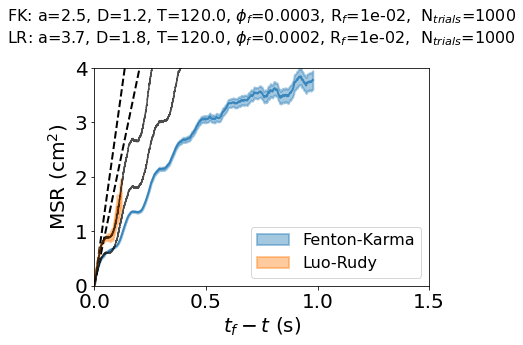

In [10]:
xv=np.linspace(0,1e3,200)
# a2=a_hat_LR
# a1=a_hat_FK
a2=a_osc_LR+2*D_osc_LR
a1=a_osc_FK+2*D_osc_FK
plt.plot(xv,4*a2*xv,'--',lw=2,alpha=1,c='k')
plt.plot(xv,4*a1*xv,'--',lw=2,alpha=1,c='k')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0',label='Fenton-Karma')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1',label='Luo-Rudy')

plt.plot(dict_fit_fk['tdeath'],dict_fit_fk['MSR'],'k',alpha=0.7)
plt.plot(dict_fit_lr['tdeath'],dict_fit_lr['MSR'],'k',alpha=0.7)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (s)',ylabel=r'MSR (cm$^2$)')
title= "FK: "+dict_fit_fk['title']
title+= "LR: "+dict_fit_lr['title']
plt.title(title,fontsize=16)
plt.xlim([0,1.5])
plt.ylim([0,4])
# plt.xlim([0,1])
# plt.ylim([0,3])
plt.legend(fontsize=16,loc='lower right')
plt.show()

- Question: does FK model diverge from 4a*tdeath for some tdeath<10 seconds?
- Answer: it doesn't appear so, 

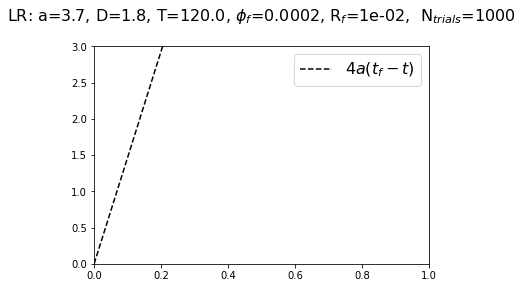

In [11]:
#TODO: plot ^those results zoomed out a bit
#FK values
ax=None
if ax is None:
    ax=plt.gca()
xmin=0
xmax=1
xv=np.linspace(xmin,xmax,100)
show_inputted_a=True
show_label_black_dotted=True
show_title=True
show_legend=True
if show_inputted_a:
    if show_label_black_dotted:
        ax.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
    else:
        ax.plot(xv,4*a*xv,'k--')#,label=r'$4a(t_f-t)$')

        
# ax.plot(t_values,MSR_values,c=c,label=label)
if show_title:
    plt.title(title,fontsize=16)
if show_legend:
    plt.legend(fontsize=16)

title= "FK: "+dict_fit_fk['title']
title= "LR: "+dict_fit_lr['title']
plt.title(title,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

## a number of token plots

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=6.4725662429671535
Delta_m=0.0012736821003302401
b=-0.04036177023917897
Delta_b=0.0007353551882800981
Rsquared=0.9989930434793577
num_samples=1000
num_timepoints=100000
ahat = 1.6181+/-0.0003
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=9.75912443869493
Delta_m=0.0024757256604197404
b=-0.03477565137848693
Delta_b=0.0014293501562719609
Rsquared=0.9983276176265216
num_samples=1000
num_timepoints=100000
ahat = 2.4398+/-0.0006


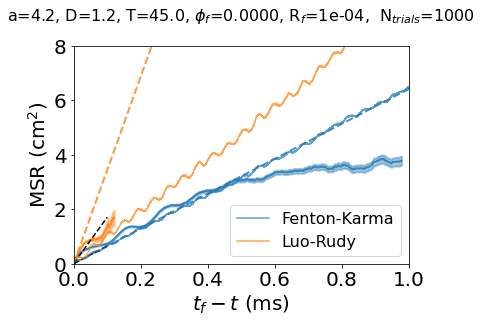

In [12]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi

#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')

# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.8,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')

dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5/2,D=1.2,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,8])
plt.show()

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=6.484263223213212
Delta_m=0.0013338666702567745
b=-0.029243718283745057
Delta_b=0.0007701025053213034
Rsquared=0.9988997164243925
num_samples=1000
num_timepoints=100000
ahat = 1.6211+/-0.0003
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=9.700479113406441
Delta_m=0.002791952261801372
b=0.006361009062302969
Delta_b=0.0016119223004026453
Rsquared=0.9978483416271332
num_samples=1000
num_timepoints=100000
ahat = 2.4251+/-0.0007


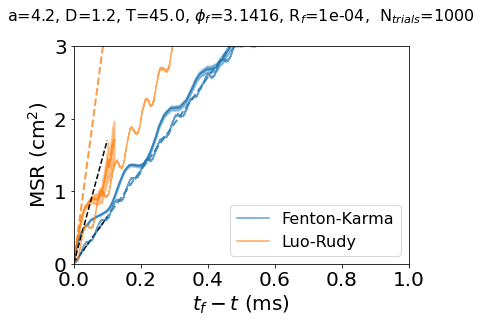

In [13]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
initial_phase_orientation=np.pi

#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')

# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.8,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5/2,D=1.2,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=6.541401222900233
Delta_m=0.001210769154982983
b=0.005841332063536875
Delta_b=0.000699032654769505
Rsquared=0.9991090093062245
num_samples=1000
num_timepoints=100000
ahat = 1.6354+/-0.0003
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=9.957384563319726
Delta_m=0.002424273860392522
b=0.08995696432320788
Delta_b=0.001399644668468878
Rsquared=0.9984594266182337
num_samples=1000
num_timepoints=100000
ahat = 2.4893+/-0.0006


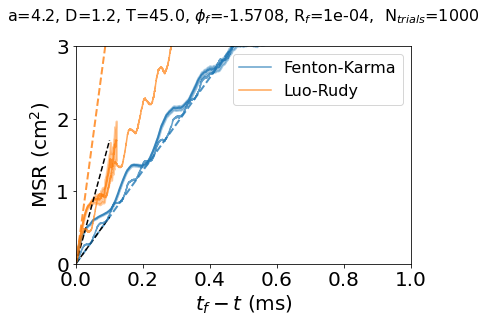

In [14]:
initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
# initial_phase_orientation=np.pi

#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')

# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.8,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')

dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5/2,D=1.2,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=4.8864324862061554
Delta_m=0.0010934073341859656
b=0.0033913981302871044
Delta_b=0.0006312742841315652
Rsquared=0.9986983516735044
num_samples=1000
num_timepoints=100000
ahat = 1.2216+/-0.0003
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=5.102913168500738
Delta_m=0.003760191321744432
b=0.36623429411429953
Delta_b=0.0021709311897008194
Rsquared=0.9860630612919711
num_samples=1000
num_timepoints=100000
ahat = 1.2757+/-0.0009


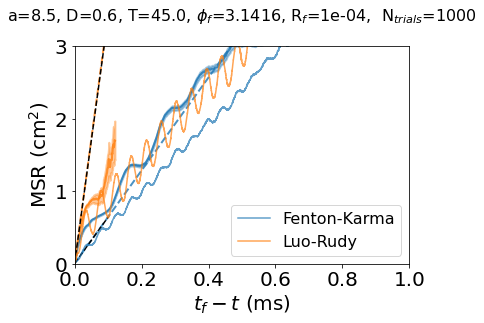

In [15]:
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

# generate a figure panel showing the good agreement between the full models and the oscillatory model

In [11]:
# a_FK = 1.604153#+/-0.040173 cm^2/s, tmax=300
# a_LR = 2.245111#+/-0.224026 cm^2/s, tmax=90
# # a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8

# LR: z=2*pi*(15.5618+/- 1.867684 ms)/(120+/-20 ms)
# FK: z=2*pi*(197.3891+/- 35.600166 ms)/(110+/-10 ms)
G_over_T_LR=15.5618/120
G_over_T_FK=197.3891/110

print(f"for G_over_T_FK: {G_over_T_FK:.4f}")
print(f"for G_over_T_LR: {G_over_T_LR:.4f}")

# G_over_T=1/6
G_over_T=G_over_T_LR
z=2*np.pi*G_over_T
ahat_over_a=1+1/z+z/(1+z**2)
ahat_over_a_LR=ahat_over_a
# ahat_over_a_LR

# G_over_T=2
G_over_T=G_over_T_FK
z=2*np.pi*G_over_T
ahat_over_a=1+1/z+z/(1+z**2)
ahat_over_a_FK=ahat_over_a
# ahat_over_a_FK

a_LR = 3.535902#+/-0.312245 cm^2/s, tmax=60
a_FK = 1.604153#+/-0.040173 cm^2/s, tmax=300
ahat_expected_FK=ahat_over_a_FK*a_FK
ahat_expected_LR=ahat_over_a_LR*a_LR
print(f"ahat_expected_FK={ahat_expected_FK:.4f}")
print(f"ahat_expected_LR={ahat_expected_LR:.4f}")

for G_over_T_FK: 1.7944
for G_over_T_LR: 0.1297
ahat_expected_FK=1.8876
ahat_expected_LR=9.6069


Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=6.549418863445452
Delta_m=0.0012665449811728657
b=0.0029358197052227197
Delta_b=0.0007312346015179949
Rsquared=0.9990274939410086
num_samples=1000
num_timepoints=100000
ahat = 1.6374+/-0.0003
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=14.305989411099661
Delta_m=0.002841151863755694
b=-0.08769069568819621
Delta_b=0.0016403274907943806
Rsquared=0.9989743796744507
num_samples=1000
num_timepoints=100000
ahat = 3.5765+/-0.0007


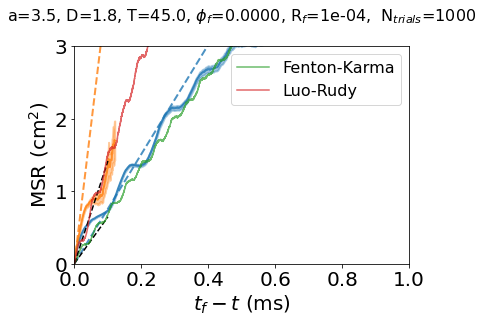

In [18]:
initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
# initial_phase_orientation=np.pi

#plot expected
fig,ax=plt.subplots(figsize=(6,4))
xv=np.linspace(0,1e3,200)
#plot the lines of effective attraction coefficient
# plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
# plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
plt.plot(xv,4*ahat_expected_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*ahat_expected_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot the full models
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
#plot the oscillatory particle model
dict_fit_fk=visualize_model_oscillatory_reversed(a=a_FK,D=a_FK/2,initial_phase_orientation=-np.pi/2,c='C2',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=a_LR,D=a_LR/2,initial_phase_orientation=0,c='C3',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

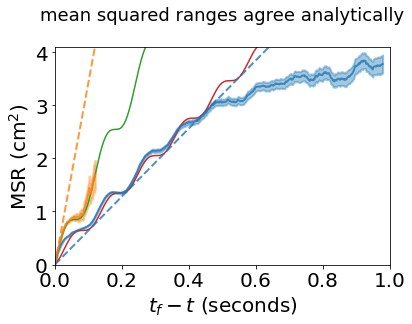

In [19]:
fig,ax=plt.subplots(figsize=(6,4))

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# plot ^this model for MSR for fitty parameter settings (LR)
a=3.535902;D=a/2;
phi_f=0.;
# phi_f=-np.pi/2;
period=0.12 #s
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C2',
        label='$MSR_{Osc.} (a=a_{LR},\phi_f=0$)')
#         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'$MSR_{Osc.} (a=a_{FK}, \phi_f=-\frac{\pi}{2})$')


xv=np.linspace(0,1,200)
#plot the lines of effective attraction coefficient
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot the full models
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)')

plt.title('mean squared ranges agree analytically\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.1])
plt.show()

In [20]:
#compute the oscillatory particle model
kwargs_fk=dict(a=1.604153, D=1.604153/2, initial_phase_orientation=-np.pi/2, period_of_oscillation=110, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
# kwargs_lr=dict(a=3.535902, D=3.535902/2, initial_phase_orientation=-np.pi/2, period_of_oscillation=120, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
#                xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
kwargs_lr=dict(a=3.535902, D=3.535902/2, initial_phase_orientation=0, period_of_oscillation=120, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
dict_fit_fk=visualize_model_oscillatory_reversed(ax=ax,c='C0',label='Simulation of Osc. (FK)', **kwargs_fk)
dict_fit_lr=visualize_model_oscillatory_reversed(ax=ax,c='C1',label='Simulation of Osc. (LR)', **kwargs_lr)
plt.close()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


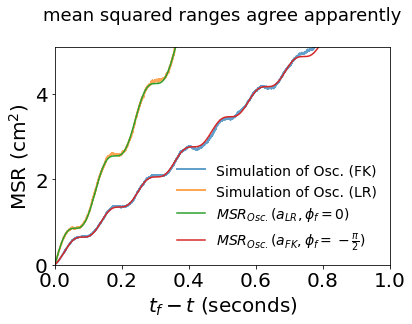

In [21]:
fig,ax=plt.subplots(figsize=(6,4))


#plot the oscillatory particle model
plt.plot(dict_fit_fk['tdeath'],dict_fit_fk['MSR'],lw=2,alpha=0.7,c='C0',label='Simulation of Osc. (FK)')
plt.plot(dict_fit_lr['tdeath'],dict_fit_lr['MSR'],lw=2,alpha=0.7,c='C1',label='Simulation of Osc. (LR)')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;
phi_f=0.;
# phi_f=-np.pi/2;
period=0.12 #s
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C2',
        label=r'$MSR_{Osc.} (a_{LR}, \phi_f=0)$')
#         label=r'$MSR_{Osc.} (a_{LR}, \phi_f=-\frac{\pi}{2})$')
#         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'$MSR_{Osc.} (a_{FK}, \phi_f=-\frac{\pi}{2})$')

# #plot the full models
# plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
# plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
# plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
# plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# #plot the lines of effective attraction coefficient
# xv=np.linspace(0,1,200)
# plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
# plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')

plt.legend(fontsize=14,frameon=False)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)')
plt.title('mean squared ranges agree apparently\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,5.1])
plt.show()

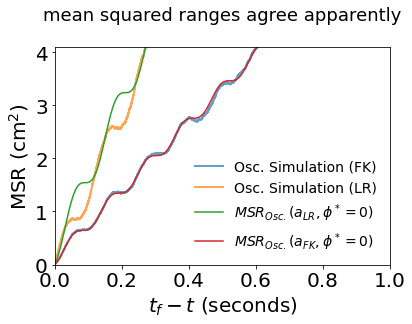

In [22]:
fig,ax=plt.subplots(figsize=(6,4))

#plot the oscillatory particle model
plt.plot(dict_fit_fk['tdeath'],dict_fit_fk['MSR'],lw=2,alpha=0.7,c='C0',label='Osc. Simulation (FK)')
plt.plot(dict_fit_lr['tdeath'],dict_fit_lr['MSR'],lw=2,alpha=0.7,c='C1',label='Osc. Simulation (LR)')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;
# phi_f=0.;
phi_f=-np.pi/2;
period=0.12 #s
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C2',
        label=r'$MSR_{Osc.} (a_{LR},\phi^*=0)$')
#         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'$MSR_{Osc.} (a_{FK},\phi^*=0)$')

# #plot the full models
# plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
# plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
# plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
# plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# #plot the lines of effective attraction coefficient
# xv=np.linspace(0,1,200)
# plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
# plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')

plt.legend(fontsize=14,frameon=False)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)')
plt.title('mean squared ranges agree apparently\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.1])
plt.show()

# verify the functional form of the analytic MSR model agrees with direct simulation of the oscillatory particle model

$\text{MSR}_\text{Osc.}(t')=4\Big(2\tilde{D}t'+\frac{a}{\omega} \big(\sin(\omega t' + \phi_f)-\sin(\phi_f)\big)\Big)$

In [32]:
a=1.604153
D=a/4
initial_phase_orientation=-np.pi/2
period_of_oscillation=110
#compute the oscillatory particle model
kwargs_fk=dict(a=a, D=D, initial_phase_orientation=initial_phase_orientation, period_of_oscillation=period_of_oscillation, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
dict_fit_fk=visualize_model_oscillatory_reversed(ax=None,c='C0',label='Simulation of Osc. (FK)', **kwargs_fk)
plt.close()

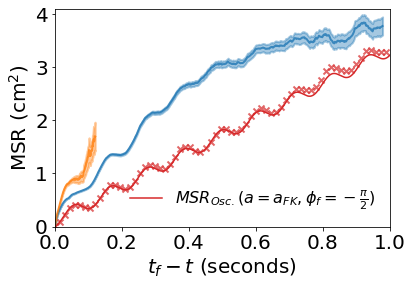

In [34]:
#plot MSR_Osc over the direct simulation results
fig,ax=plt.subplots(figsize=(6,4))

#what param setting to use for the FK model?
phi_f=initial_phase_orientation
period=period_of_oscillation*1e-3 #seconds
# constant=0.15
omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')

#plot the full models
ax.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
ax.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

#format_plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=20)
plt.legend(fontsize=16,frameon=False)

#plot the oscillatory particle model
stepsize=1500
plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='C3',marker='x')#,label='Simulation of Osc. (FK)')
# plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C2',marker='x')#,label='Simulation of Osc. (LR)')

# plt.title('mean squared ranges agree\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.1])
# plt.ylim([0,14.1])
plt.show()

# verify the functional form of the analytic MSR model agrees with direct simulation of the linear particle model

$\text{MSR}_\text{Lin.}(t')=4\Big(2Dt'+\hat{a}t'\Big)$

In [38]:
# from lib.model.reversed_time_oscillatory_model import visualize_model_oscillatory_reversed

In [ ]:
# np.isclose(period_of_oscillation,0.)


In [33]:
# a=1.604153
a=1.604153 - 2*0.365
D=0.365#FK 2*a
# D=0#a/8
# a=0
# D=1.6/2
initial_phase_orientation=0#linear particle model
period_of_oscillation=0#110
#compute the linear particle model
kwargs_fk=dict(a=a, D=D, initial_phase_orientation=initial_phase_orientation, period_of_oscillation=period_of_oscillation, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=False)#, c='C3', label='Simulation')
dict_fit_fk=visualize_model_oscillatory_reversed(ax=None,c='C0',label='Simulation of Osc. (FK)', **kwargs_fk)
plt.close()

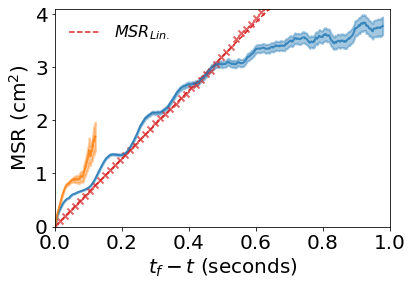

alinear=0.8742, Dlinear=0.3650, 


In [34]:
#plot MSR_Osc over the direct simulation results
fig,ax=plt.subplots(figsize=(6,4))

#what param setting to use for the FK model?
# constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
# MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
# ax.plot(t_values,MSR_values_oscillatory,c='C3',
#                 label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')
MSR_values_linear=4*(2*D*t_values+a*t_values)
ax.plot(t_values,MSR_values_linear,'--',c='C3',
                label=r'$MSR_{Lin.}$')
#                 label=r'$MSR_{Lin.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')
#plot the full models
ax.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
ax.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

#format_plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=20)
plt.legend(fontsize=16,frameon=False)

#plot the oscillatory particle model
stepsize=1500
plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='C3',marker='x')#,label='Simulation of Osc. (FK)')
# plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C2',marker='x')#,label='Simulation of Osc. (LR)')

# plt.title('mean squared ranges agree\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.1])
# plt.ylim([0,14.1])
# plt.ylim([0,34.1])
plt.show()
print(f"alinear={a:.4f}, Dlinear={D:.4f}, ")

# generate MSR plot using the affine oscillatory particle model
- DONE: verify the functional form of the analytic MSR model agrees with direct simulation of the affine oscillatory particle model

$\text{MSR}_\text{Aff.Osc.}(t')=4\Big(2Dt'+a_0t'+\frac{a_1}{\omega} \big(\sin(\omega t' + \phi_f)-\sin(\phi_f) \big)\Big)$

$\text{MSR}_\text{Aff.Osc.}(t')=4\Big(2\tilde{D}t'+a_0t'+\frac{a}{\omega} \big(\sin(\omega t' + \phi_f)-\sin(\phi_f) \big)\Big)$

Perhaps,
$\text{MSR}_\text{Aff.Osc.}(t')=4\Big(2\tilde{D}t'+\hat{a}t'+\frac{a}{\omega} \big(\sin(\omega t' + \phi_f)-\sin(\phi_f) \big)\Big)$

$\text{MSR}_\text{Aff.Osc.}(t')=4\Big(2\tilde{D}t'+a_0t'+\frac{a_1}{\omega} \big(\sin(\omega t' + \phi_f)-\sin(\phi_f) \big)\Big)$

In [97]:
#TODO: cp WJ's fit here:
a0=5.4958675607488825 #cm^2/s
a1=6.2229999145162314 #cm^2/s
period=179.51957944083097 #ms
# phase=1.1497012691466562
phase=0
# phase=-1.1497012691466562
alinear=9.6723775587961800
D=0.58
#TODO: set the LR model's fit to WJ's fit
# D_osc_FK
a=a1
initial_phase_orientation= phase
period_of_oscillation    = period # 110
# period_of_oscillation=0

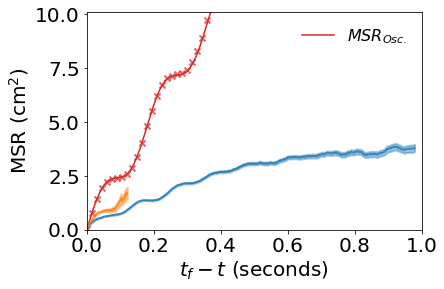

In [98]:
# # a=1.604153/2 #FK
# # D=0.365 #FK
# # a0=1.604153 #FK

# # a=1.604153/2 #FK
# a=1.604153 #FK
# a0=1.604153 - 2*0.365
# D=0.365
# # a=1.604153
# # D=D_FK    #a/4
# # a0=a

# initial_phase_orientation=-np.pi/2
# period_of_oscillation=110
# # period_of_oscillation=0
# num_pairs=1000
num_pairs=500
#compute the oscillatory particle model
kwargs_fk=dict(a=a, D=D, initial_phase_orientation=initial_phase_orientation, period_of_oscillation=period_of_oscillation, a0=a0, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, 
               printing=False, plotting=False)#, c='C3', label='Simulation')
dict_fit_fk=visualize_model_oscillatory_reversed(ax=None,c='C0',label='Simulation of Osc. (FK)', **kwargs_fk)
# plt.close()

#plot MSR_Osc over the direct simulation results
fig,ax=plt.subplots(figsize=(6,4))

#what param setting to use for the FK model?
phi_f=initial_phase_orientation
period=period_of_oscillation*1e-3 #seconds
# constant=0.15
omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_affoscillatory=4*((2*D+a0)*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
ax.plot(t_values,MSR_values_affoscillatory,c='C3',
                label=r'$MSR_{Osc.}$')
#                 label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')

#plot the full models
ax.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
ax.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

#format_plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=20)
plt.legend(fontsize=16,frameon=False)

#plot the oscillatory particle model
stepsize=1500
plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='C3',marker='x')#,label='Simulation of Osc. (FK)')
# plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C2',marker='x')#,label='Simulation of Osc. (LR)')

# plt.title('mean squared ranges agree\n',fontsize=18)
plt.xlim([0,1])
# plt.ylim([0,4.1])
plt.ylim([0,10.1])
plt.show()

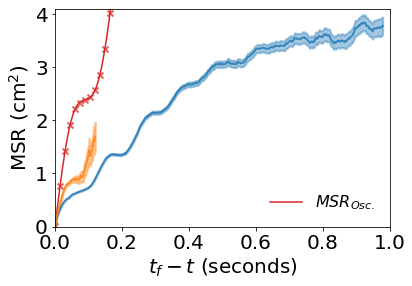

In [99]:
#plot MSR_Osc over the direct simulation results
fig,ax=plt.subplots(figsize=(6,4))

#what param setting to use for the FK model?
phi_f=initial_phase_orientation
period=period_of_oscillation*1e-3 #seconds
# constant=0.15
# omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_affoscillatory=4*((2*D+a0)*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
ax.plot(t_values,MSR_values_affoscillatory,c='C3',
                label=r'$MSR_{Osc.}$')
#                 label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')

#plot the full models
ax.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
ax.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

#format_plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=20)
plt.legend(fontsize=16,frameon=False)

#plot the oscillatory particle model
stepsize=1500
plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='C3',marker='x')#,label='Simulation of Osc. (FK)')
# plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C2',marker='x')#,label='Simulation of Osc. (LR)')

# plt.title('mean squared ranges agree\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.1])
# plt.ylim([0,14.1])
plt.show()

In [100]:
printing=True
#DONE: quantify the goodness of fit of the model
x_values=x_values_LR*1e-3
y_values=y_values_LR
yhat_values=4*((2*D+a0)*x_values+(a/omega)*(np.sin(omega*x_values+phi_f)-np.sin(phi_f)))
RMSE_LR=np.sqrt(np.mean((yhat_values-y_values)**2))
Rsq_LR = np.corrcoef(yhat_values,y_values)[0,1]**2
yhaterr_values_LR=yhat_values-y_values
if printing:
    Rsq=Rsq_LR
    RMSE=RMSE_LR
    print(f"Aff.Osc. Parameter Settings: {D=:.4f}, {a0=:.4f}, {a1=:.4f} cm^2/s, {period=:.4f} ms, {phase=:.4f} rad. --> {alinear=:.4f} cm^2/s.")
    print(f"Goodness of fit to LR model: {RMSE=:.4f} cm^2, R^2={Rsq:.4f}, (N_points={x_values_LR.shape[0]})") 

Aff.Osc. Parameter Settings: D=0.5800, a0=5.4959, a1=6.2230 cm^2/s, period=0.1795 ms, phase=0.0000 rad. --> alinear=9.6724 cm^2/s.
Goodness of fit to LR model: RMSE=1.0427 cm^2, R^2=0.7921, (N_points=119)


- Aff.Osc. Parameter Settings: D=0.5800, a0=5.4959, a1=6.2230 cm^2/s, period=0.1795 ms, phase=1.1497 rad. --> 
- alinear=9.6724 cm^2/s.
- Goodness of fit to LR model: RMSE=0.0743 cm^2, R^2=0.9804, (N_points=119)


In [52]:
# Adjusted R2 = 1 – [(1-R2)*(n-1)/(n-k-1)]

# where:

# R2: The R2 of the model
# n: The number of observations
# k: The number of predictor variables

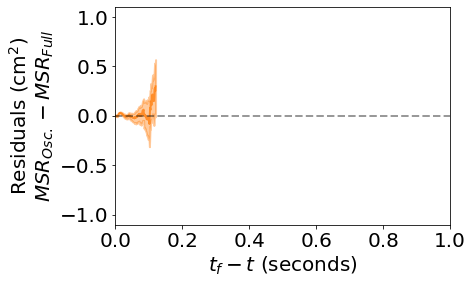

In [66]:
fig,ax=plt.subplots(figsize=(6,4))
#plot of residuals
ax.plot(x_values_LR*1e-3,yhaterr_values_LR,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_LR*1e-3,yhaterr_values_LR-yerr_values_LR,yhaterr_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

#plot horizontal dotted line for zero residuals
xv=np.linspace(0,1,100)
plt.plot(xv,0.*xv,'k--',alpha=0.4,lw=2)
#format_plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'Residuals (cm$^2$)'+'\n'+r'$MSR_{Osc.}-MSR_{Full}$',fontsize=20)
# plt.legend(fontsize=16,frameon=False)

#plot the oscillatory particle model
# stepsize=1500
# plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='C3',marker='x')#,label='Simulation of Osc. (FK)')
# plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C2',marker='x')#,label='Simulation of Osc. (LR)')

# plt.title('mean squared ranges agree\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([-1.1,1.1])
# plt.xlim([-10,10])
# plt.ylim([-20.1,20.1])
# plt.ylim([0,14.1])
plt.show()

In [73]:
a0=5.4958675607488825 #cm^2/s
a1=6.2229999145162314 #cm^2/s
period=179.51957944083097 #ms
phase=1.1497012691466562
Gamma = 20 #ms
omega = 2*np.pi/period
z = Gamma*omega

alinear=(a0 + a1 + a0*z**2)/(1 + z**2)
print(f"{a0=:.4f}, {a1=:.4f}, {z=:.4f} --> {alinear=:.4f}")

a0=5.4959, a1=6.2230, z=0.7000 --> alinear=9.6724


# Equations Relating Aff. Osc. to Linear

## MSR-Consistent Theory

Our hypothesis is that the range between particles is consistent between the two particle models in the mean square.  In other words,
$$
\mathbb{E}_{\Gamma/2}\Big[\text{MSR}_\text{Lin.}\Big] \overset{!}{=} \mathbb{E}_{\Gamma/2}\Big[\text{MSR}_\text{Aff.Osc}\Big].
$$

Let $z=\omega(\Gamma/2)$, $D_\text{Aff.Osc.}=D_\text{Lin.}=D=$constant, and let $\phi_f=0$. Then, the aforementioned _ansatz_ simplifies to

$$
a_\text{Lin.}=a_0 + \frac{a_1}{1+z^2}.
$$


For general $\phi_f\in\mathbb{R}$, the aforementioned _ansatz_ simplifies to

$$
a_\text{Lin.}=a_0 + a_1\frac{\cos(\phi_f)-z\sin(\phi_f)}{1+z^2}.
$$

In [12]:
#WJ'S FIT
#predicted values
a0=5.4958675607488825 #cm^2/s
a1=6.2229999145162314 #cm^2/s
period=179.51957944083097 #ms
# phase=1.1497012691466562
# phase=0
phase=-1.1497012691466562
Gamma = 20 #ms
omega = 2*np.pi/period
z = Gamma*omega

alinear=a0 + a1*(np.cos(phase)-z*np.sin(phase))/(1 + z**2)
print(f"{a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f}")


a0=5.4959, a1=6.2230, z=0.7000, phase=-1.1497 --> alinear=9.8712


$$
\phi_f=-\frac{\pi}{2}
$$

$$
\phi_f=\frac{3\pi}{2}
$$

## DONT: investigate SMSR-Consistent Theory or VarMSR-Consistent Theory

Our hypothesis is that the range between particles is consistent between the two particle models in the square mean square.  In other words,
$$
\mathbb{E}_{\Gamma/2}\Big[\text{MSR}^2_\text{Lin.}\Big] \overset{!}{=} \mathbb{E}_{\Gamma/2}\Big[\text{MSR}^2_\text{Aff.Osc}\Big].
$$

Let $z=\omega(\Gamma/2)$, $D_\text{Aff.Osc.}=D_\text{Lin.}=D=$constant, and let $\phi_f$ be general, \****heave***\* oh..., it's hideous...

## repeat for FK model

## step 1: compute fit of MSR from FK model to parameter settings from the affine oscillatory particle model

In [13]:
import numpy as np
from scipy.optimize import minimize

In [19]:
# def get_comp_square_error_msr(t_values,msr_values,D=0.365,**kwargs):
#     """computes the sum of the square errors between the input msr(t)_values 
#     and the fit predicted by the affine oscillatory particle model.
    
#     Example Usage:
# comp_square_error_msr=get_comp_square_error_msr(t_values,msr_values,D)
# square_error_msr=comp_square_error_msr(a0,a1,period,phase)
# print(f"{square_error_msr=}")
#     """
#     def comp_square_error_msr(a0,a1,period,phase):
#         """phase is in radians. period is in milliseconds.  a0,a1 are in cm^2/s.
        
#     Example Usage:
# comp_square_error_msr=get_comp_square_error_msr(t_values,msr_values,D)
# square_error_msr=comp_square_error_msr(a0,a1,period,phase)
# print(f"{square_error_msr=}")
#         """
#         period_of_oscillation=period*1e-3 #seconds
#         omega=2*np.pi/period_of_oscillation
#         msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
#         square_error_msr=np.sum((msr_values_affoscillatory-msr_values)**2)
#         return square_error_msr
#     return comp_square_error_msr


In [105]:
#select msr from the full models for fitting
max_tdeath=300. #ms


#INPUT: FK MODEL
boo=x_values_FK<max_tdeath
t_values=x_values_FK[boo].copy()*1e-3
msr_values=y_values_FK[boo].copy()
D=0.365 #cm^2/s, as observed
Gamma = 100. # ~ 197/2 #ms #for predicting alinear only
 
#INPUT: LR MODEL
boo=x_values_LR<max_tdeath
t_values=x_values_LR[boo].copy()*1e-3
msr_values=y_values_LR[boo].copy()
D=0.58 #cm^2/s, as observed
Gamma = 20. # ~ 40/2 #ms #for predicting alinear only


In [106]:
#initialize parameter setting
a0=5.4958675607488825 #cm^2/s
a1=6.2229999145162314 #cm^2/s
period=179.51957944083097 #ms

In [107]:
#TODO: initialize from each of these three angles and observe the final angle the data converges on.
phase=1.1497012691466562
# phase=0
# phase=-1.1497012691466562
comp_square_error_msr=get_comp_square_error_msr(t_values,msr_values,D)
square_error_msr=comp_square_error_msr(a0,a1,period,phase)
print(f"{np.log(square_error_msr)=}")
# Q: why is our period so different from the expected period?
#TODO: constrain phase=1.1497012691466562 and see what fit comes out
#TODO: constrain phase=0 and see what fit comes out
#TODO: constrain phase=-1.1497012691466562 and see what fit comes out

np.log(square_error_msr)=-0.41911957463014116


In [108]:
#confirmed: different phase values give different mse
# np.log(square_error_msr)=19.833481802230473
# np.log(square_error_msr)=19.83287832545624
# np.log(square_error_msr)=-0.41911957463014116


In [122]:
#heretim
#DONE: dev function that takes parameter values (a0,a1,period,phase) and returns se from each datum in t_values,msr_values
#TODO: find best fit
def comp_square_error_msr(x,*args):
    """phase is in radians. period is in milliseconds.  a0,a1 are in cm^2/s.

Example Usage:
x0=a0,a1,period,phase
args=t_values,msr_values,D
square_error=comp_square_error_msr(x0,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"{rmse=}")
    """
    a0,a1,period,phase=x
    t_values,msr_values,D=args
    omega=2*np.pi/period*1e3 #Hz bc period is in ms
    msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
    square_error_msr=np.sum((msr_values_affoscillatory-msr_values)**2)
    return square_error_msr

In [1]:
from scipy import optimize

In [2]:
x0 = np.array([a0,a1,period,phase]) # initial guess
params = t_values,msr_values,D
np.random.seed(42)   # seed to allow replication.
res = optimize.anneal(comp_square_error_msr, x0, args=params, schedule='fast',
                      full_output=True, maxiter=500, lower=-10,
                          upper=10, dwell=250, disp=True)



res[0]  # obtained minimum

res[1]  # function value at minimum

NameError: name 'np' is not defined

In [124]:
x0=a0,a1,period,phase
args=D,t_values,msr_values
bnds = ((0, 10), (0, 10), (40, 400), (-3.2,3.2))
# res = minimize(comp_square_error_msr, x0, args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
# res = minimize(comp_square_error_msr, x0, args, bounds=bnds,tol=1e-3)
# res = minimize(comp_square_error_msr, x0, args,tol=1e-3)
# print(f"{res.x=}")
# res.x is in the basis of a0,a1,period,phase
a0_=res.x[0];a1_=res.x[1];period_=res.x[2];phase_=res.x[3]
square_error=comp_square_error_msr(res.x,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"{a0_=:.4f}, {a1_=:.4f}, {period_=:.4f}, {phase_=:.4f}")
print(f"{rmse=}")

a0_=0.0000, a1_=10.0000, period_=40.0203, phase_=1.5938
rmse=3.9943520235711847


In [123]:
x0=a0,a1,period,phase
args=t_values,msr_values,D
square_error=comp_square_error_msr(x0,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"{a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f}")
print(f"{rmse=}")

a0=5.4959, a1=6.2230, period=179.5196, phase=1.1497
rmse=0.07433885370404265


In [130]:
# method_lst=['Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']
#jacobian needed # 'dogleg', 'Newton-CG', 'trust-ncg', 'trust-exact','trust-krylov' #jacobian needed
method_lst=['Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr']
x0=a0,a1,period,phase
args=D,t_values,msr_values
bnds = ((0, 10), (0, 10), (40, 400), (-3.2,3.2))
for method in method_lst:
    res = minimize(comp_square_error_msr, x0, args, method=method, bounds=bnds,tol=1e-3)
    # res.x is in the basis of a0,a1,period,phase
    a0_=res.x[0];a1_=res.x[1];period_=res.x[2];phase_=res.x[3]
    square_error=comp_square_error_msr(res.x,*args)
    rmse=np.sqrt(square_error/t_values.shape[0])
    print(f"{method=}: {a0_=:.4f}, {a1_=:.4f}, {period_=:.4f}, {phase_=:.4f}, {rmse=}")

method='Nelder-Mead': a0_=0.0000, a1_=10.0000, period_=129.5394, phase_=1.6418, rmse=3.009982959965514
method='Powell': a0_=0.0000, a1_=9.9993, period_=129.0123, phase_=1.5271, rmse=3.014495702933438
method='CG': a0_=-1.3491, a1_=6.4314, period_=179.3707, phase_=2.4510, rmse=1.7238980824043952
method='BFGS': a0_=-2.2601, a1_=7.5676, period_=179.6874, phase_=-7.0962, rmse=1.7238980824043955
method='L-BFGS-B': a0_=0.0000, a1_=10.0000, period_=40.0203, phase_=1.5938, rmse=3.9943520235711847
method='TNC': a0_=0.0000, a1_=10.0000, period_=89.5354, phase_=1.6617, rmse=3.4389206496061435
method='COBYLA': a0_=-1.6748, a1_=6.8244, period_=180.1514, phase_=1.1134, rmse=1.7238995007626197
method='SLSQP': a0_=0.0000, a1_=10.0000, period_=40.0193, phase_=1.5922, rmse=3.994351991965426
method='trust-constr': a0_=0.0000, a1_=10.0000, period_=167.1042, phase_=1.6622, rmse=2.6357937769669246


In [ ]:
# GROUP A: everyone not in B.
# GROUP B: CG, BFGS, COBYLA
# # CONSIDER RULING OUT: a0_<0 methods: CG, BFGS, COBYLA
# method='Nelder-Mead': a0_=0.0000, a1_=10.0000, period_=129.5394, phase_=1.6418, rmse=3.009982959965514
# method='Powell': a0_=0.0000, a1_=9.9993, period_=129.0123, phase_=1.5271, rmse=3.014495702933438
# # method='CG': a0_=-1.3491, a1_=6.4314, period_=179.3707, phase_=2.4510, rmse=1.7238980824043952
# # method='BFGS': a0_=-2.2601, a1_=7.5676, period_=179.6874, phase_=-7.0962, rmse=1.7238980824043955
# method='L-BFGS-B': a0_=0.0000, a1_=10.0000, period_=40.0203, phase_=1.5938, rmse=3.9943520235711847
# method='TNC': a0_=0.0000, a1_=10.0000, period_=89.5354, phase_=1.6617, rmse=3.4389206496061435
# # method='COBYLA': a0_=-1.6748, a1_=6.8244, period_=180.1514, phase_=1.1134, rmse=1.7238995007626197
# method='SLSQP': a0_=0.0000, a1_=10.0000, period_=40.0193, phase_=1.5922, rmse=3.994351991965426
# method='trust-constr': a0_=0.0000, a1_=10.0000, period_=167.1042, phase_=1.6622, rmse=2.6357937769669246

In [131]:
#GOAL: fit the full models without computing some jacobian.
# fix period. 
# optimize a0,a1,phase.  
# repeat for many periods.  
# choose the period that minimizes the squared error.


 barrier_parameter: 0.004000000000000001
 barrier_tolerance: 0.004000000000000001
          cg_niter: 54
      cg_stop_cond: 4
            constr: [array([3.63475399e-06, 9.99996022e+00, 1.67104167e+02, 1.66224997e+00])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.10527420043945312
               fun: 826.7416513290104
              grad: array([ 1.10094450e+03, -1.00543979e+02,  2.80970215e-04, -1.54217273e-03])
               jac: [<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([6.13908924e-12, 1.58166813e-11, 2.66653603e-04, 1.61321011e-04])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 115
              nhev: 0
               nit: 25
             niter: 25
              njev: 23
        optimality: 0.0002666536028514930

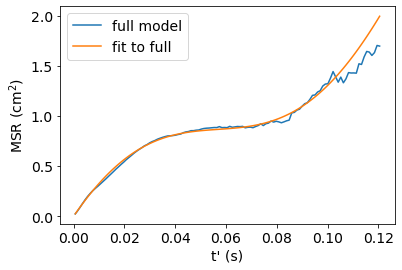

In [84]:
#TODO: visualize the fit
period_of_oscillation=period*1e-3 #seconds
omega=2*np.pi/period_of_oscillation
msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
plt.plot(t_values,msr_values,label='full model')
plt.plot(t_values,msr_values_affoscillatory,label='fit to full')
format_plot(ax=plt.gca(),xlabel=r"t' (s)",ylabel=r"MSR (cm$^2$)",fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
#TODO: quantify goodness of fit

In [95]:
#TODO: print predicted alinear
#for predicting alinear only
# Gamma = 20. # ~ 40/2 #ms 
omega = 2*np.pi/period
z = Gamma*omega
print(f"{z=:.4f}")

ValueError: not enough values to unpack (expected 5, got 3)

In [ ]:
# #TODO: compute the resulting annihilation rates
# r=res.x[0]
# kappa=res.x[1]
# X=np.array([[r,kappa,a,D]])
# yhat = interp(X)
# nu=yhat[0,0]
# M=yhat[0,1]
# # M=yhat[0,2]
# what_values=M*q_values**nu


In [ ]:
# #TODO: plot the result over the original annihilation rates
# title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
# plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
# plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
# format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
# plt.legend(fontsize=15)
# plt.title(title,fontsize=15)
# plt.show()
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

In [ ]:
alinear=a0 + a1*(np.cos(phase)-z*np.sin(phase))/(1 + z**2)
print(f"{a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f}")


## step 2: plot fit

In [50]:
#compute the oscillatory particle model
# kwargs_fk=dict(a=1.604153, D=1.604153/2, initial_phase_orientation=-np.pi/2, period_of_oscillation=110, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
#                xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
# # kwargs_lr=dict(a=3.535902, D=3.535902/2, initial_phase_orientation=-np.pi/2, period_of_oscillation=120, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
# #                xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
a=3.535902
D=0.58
# a0=3.535902-2*0.58
a0=2.375902
num_pairs=500
initial_phase_orientation=0
period_of_oscillation=120
#compute the oscillatory particle model
kwargs_lr=dict(a=a, D=D, initial_phase_orientation=initial_phase_orientation, period_of_oscillation=period_of_oscillation, a0=a0, num_pairs=num_pairs, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, 
               printing=False, plotting=False)#, c='C3', label='Simulation')
dict_fit_lr=visualize_model_oscillatory_reversed(ax=None,c='C1',label='Simulation of Osc. (LR)', **kwargs_lr)


# kwargs_lr=dict(a=3.535902, D=3.535902/2, initial_phase_orientation=0, period_of_oscillation=120, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
#                xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
# dict_fit_fk=visualize_model_oscillatory_reversed(ax=None,c='C0',label='Simulation of Osc. (FK)', **kwargs_fk)
# dict_fit_lr=visualize_model_oscillatory_reversed(ax=None,c='C1',label='Simulation of Osc. (LR)', **kwargs_lr)
# plt.close()

In [ ]:
# a=3.535902;D=a/2;
# phi_f=0.;
# # phi_f=-np.pi/2;
# period=0.12 #s
# omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# ax.plot(t_values,MSR_values_oscillatory,c='C2',
#         label='$MSR_{Osc.}(a=a_{LR},\phi_f=0$)')

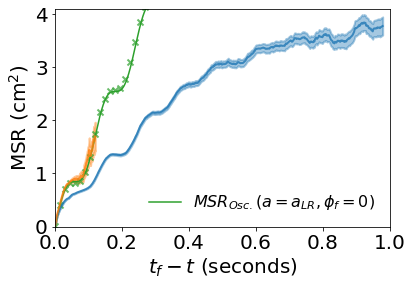

In [46]:
#heretim
# a=1.604153/2 #FK
# D=0.365 #FK
# a0=1.604153 #FK

# # a=1.604153/2 #FK
# a=1.604153 #FK
# a0=1.604153 - 2*0.365
# D=0.365

# # a=1.604153/2 #LR
# a=3.535902 #LR
# a0=3.535902 - 2*0.58
# D=0.58

# a=1.604153
# D=D_FK    #a/4
# a0=a
num_pairs=1000
num_pairs=500
# initial_phase_orientation=-np.pi/2
# period_of_oscillation=110

# initial_phase_orientation=0
# period_of_oscillation=120
# # period_of_oscillation=0
# #compute the oscillatory particle model
# kwargs_fk=dict(a=a, D=D, initial_phase_orientation=initial_phase_orientation, period_of_oscillation=period_of_oscillation, a0=a0, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
#                xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, 
#                printing=False, plotting=False)#, c='C3', label='Simulation')
# dict_fit_fk=visualize_model_oscillatory_reversed(ax=None,c='C0',label='Simulation of Osc. (FK)', **kwargs_fk)
# # plt.close()

#plot MSR_Osc over the direct simulation results
fig,ax=plt.subplots(figsize=(6,4))

#what param setting to use for the FK model?
phi_f=initial_phase_orientation
period=period_of_oscillation*1e-3 #seconds
# constant=0.15
omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_affoscillatory=4*((2*D+a0)*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
# ax.plot(t_values,MSR_values_affoscillatory,c='C3',
#                 label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')
ax.plot(t_values,MSR_values_affoscillatory,c='C2',
        label='$MSR_{Osc.}(a=a_{LR},\phi_f=0$)')

#plot the full models
ax.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
ax.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

#format_plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=20)
plt.legend(fontsize=16,frameon=False)

#plot the oscillatory particle model
stepsize=1500
# plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='C3',marker='x')#,label='Simulation of Osc. (FK)')
plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C2',marker='x')#,label='Simulation of Osc. (LR)')

# plt.title('mean squared ranges agree\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.1])
# plt.ylim([0,14.1])
plt.show()

# generate a figure panel showing the good agreement between the oscillatory model and the analytic oscillatory model (MSR Figure Panel For Main Text)

In [12]:
#compute the oscillatory particle model
kwargs_fk=dict(a=1.604153, D=1.604153/2, initial_phase_orientation=-np.pi/2, period_of_oscillation=110, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
# kwargs_lr=dict(a=3.535902, D=3.535902/2, initial_phase_orientation=-np.pi/2, period_of_oscillation=120, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
#                xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
kwargs_lr=dict(a=3.535902, D=3.535902/2, initial_phase_orientation=0, period_of_oscillation=120, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
dict_fit_fk=visualize_model_oscillatory_reversed(ax=None,c='C0',label='Simulation of Osc. (FK)', **kwargs_fk)
dict_fit_lr=visualize_model_oscillatory_reversed(ax=None,c='C1',label='Simulation of Osc. (LR)', **kwargs_lr)
plt.close()

In [15]:
# a_FK = 1.604153#+/-0.040173 cm^2/s, tmax=300
# a_LR = 2.245111#+/-0.224026 cm^2/s, tmax=90
# # a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8

# LR: z=2*pi*(15.5618+/- 1.867684 ms)/(120+/-20 ms)
# FK: z=2*pi*(197.3891+/- 35.600166 ms)/(110+/-10 ms)
G_over_T_LR=15.5618/120
G_over_T_FK=197.3891/110

print(f"for G_over_T_FK: {G_over_T_FK:.4f}")
print(f"for G_over_T_LR: {G_over_T_LR:.4f}")

# G_over_T=1/6
G_over_T=G_over_T_LR
z=2*np.pi*G_over_T
ahat_over_a=1+1/z+z/(1+z**2)
ahat_over_a_LR=ahat_over_a
# ahat_over_a_LR

# G_over_T=2
G_over_T=G_over_T_FK
z=2*np.pi*G_over_T
ahat_over_a=1+1/z+z/(1+z**2)
ahat_over_a_FK=ahat_over_a
# ahat_over_a_FK

a_LR = 3.535902#+/-0.312245 cm^2/s, tmax=60
a_FK = 1.604153#+/-0.040173 cm^2/s, tmax=300
ahat_expected_FK=ahat_over_a_FK*a_FK
ahat_expected_LR=ahat_over_a_LR*a_LR
print(f"ahat_expected_FK={ahat_expected_FK:.4f}")
print(f"ahat_expected_LR={ahat_expected_LR:.4f}")

for G_over_T_FK: 1.7944
for G_over_T_LR: 0.1297
ahat_expected_FK=1.8876
ahat_expected_LR=9.6069


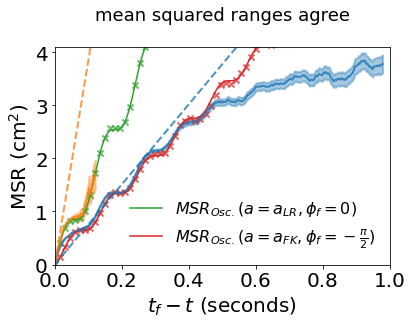

In [16]:
fig,ax=plt.subplots(figsize=(6,4))

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;
phi_f=0.;
# phi_f=-np.pi/2;
period=0.12 #s
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C2',
        label='$MSR_{Osc.}(a=a_{LR},\phi_f=0$)')
#         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')


xv=np.linspace(0,1,200)
#plot the lines of effective attraction coefficient
#plot the lines of effective attraction coefficient
# plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
# plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
plt.plot(xv,4*ahat_expected_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*ahat_expected_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot the full models
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')


format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=20)
plt.legend(fontsize=16,frameon=False)

#plot the oscillatory particle model
stepsize=1500
plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='C3',marker='x')#,label='Simulation of Osc. (FK)')
plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C2',marker='x')#,label='Simulation of Osc. (LR)')

plt.title('mean squared ranges agree\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.1])
plt.show()

# (ignore) visualize a token individual trial from the time-reversed oscillatory model

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=4.8864324862061554
Delta_m=0.0010934073341859656
b=0.0033913981302871044
Delta_b=0.0006312742841315652
Rsquared=0.9986983516735044
num_samples=1000
num_timepoints=100000
ahat = 1.2216+/-0.0003
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=5.102913168500738
Delta_m=0.003760191321744432
b=0.36623429411429953
Delta_b=0.0021709311897008194
Rsquared=0.9860630612919711
num_samples=1000
num_timepoints=100000
ahat = 1.2757+/-0.0009


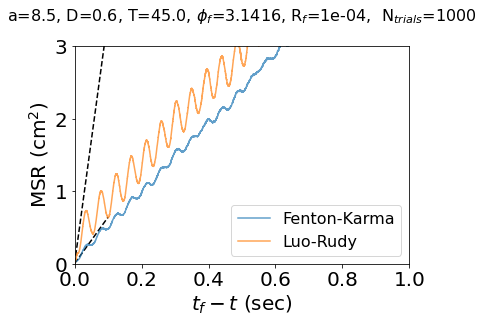

In [26]:
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

In [27]:
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma',initial)
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

SyntaxError: positional argument follows keyword argument (2486495213.py, line 2)

In [ ]:
dict_fit_fk=visualize_model_oscillatory_reversed(a=0.,D=0.6,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=0.,D=0.3,c='C1',label='Luo-Rudy')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,c='C0',label='Fenton-Karma')
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,c='C1',label='Luo-Rudy')
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
# plt.show()

In [ ]:
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,c='C1',label='Luo-Rudy')
plt.ylim((0,.05))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

# show MSR for four most-distant phases

In [ ]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
initial_phase_orientation=np.pi/2
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0,#.6,
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0,#0.3,
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.xlim(0,10)
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
#initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0,#0.6,
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0,#0.3,
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
# #initial_phase_orientation=np.pi/2
# # initial_phase_o|rientation=0.
initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0,#0.6,
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0,#0.3,
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

## repeat without diffusion

In [ ]:
# initial_phase_orientation=-np.pi/2
# #initial_phase_orientation=np.pi/2
initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
# #initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
initial_phase_orientation=np.pi/2
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

# Visualize a number of trials, so as to paint a picture in terms of the full models

In [ ]:
1

In [ ]:
#estimated run time: 11 minutes
testing=True
if testing:
    #2 min. runtime
    a=8.5
    D=0.3
    num_pairs=400#2min 22sec: 100#1min 30sec: 10+1
    initial_phase_orientation=-np.pi/2
    #initial_phase_orientation=np.pi/2
    # initial_phase_orientation=np.pi
    #rstart=0.01#1.5,rstart=rstart
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

In [ ]:
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"

print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt
# x_values=aligned_mean_values[:,0]
# plt.plot(aligned_mean_values[:,1])
# plt.plot(aligned_mean_values[:,2])
# plt.plot(aligned_mean_values[:,3])

xmin,xmax=0,0.1
ymin,ymax=0,0.6
xv=np.linspace(xmin,xmax,100)
plt.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(t_values,MSR_values,c='C5',label=r"Simulation")
# plt.plot(t_values,aligned_mean_values[::-1,0]**2)
plt.plot(t_values,t_values*0.,'--',c='gray',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.title(title,fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [ ]:
boo=~(np.isnan(t_values)|np.isnan(MSR_values))
dict_fit=compute_95CI_ols(t_values[boo],MSR_values[boo])
print_dict(dict_fit)
print(f"num_samples={positions_out.shape[-1]}")
print(f"num_timepoints={t_values.shape[0]}")
print(f"ahat = {dict_fit['m']/4:.4f}+/-{dict_fit['Delta_m']/4:.4f}")

__Interacting Particle Models that could potentially explain the apparent disagreement for the Luo-Rudy model at long time scales__

Considering $C=\sqrt{4D}$,

$$
dR = \frac{-2a}{R}dt + CdW(t).
$$

The attracting inverse_powerlaw_model be changed to the fractional_powerlaw_model:

$$
dR = \frac{-2a}{R^b}dt + CdW(t)
$$

for $b=0.716(1)$ (LR) or $b=0.797(2)$ (FK).


The attracting inverse_powerlaw_model be changed to the attracting and repelling oscillatory_powerlaw_model:

$$
dR = \frac{-2a}{R}\cos(\omega t + \phi)dt + CdW(t)
$$

for $\omega=2\pi/T$ for $T=100$ ms (LR) or for $T=90$ ms (FK).  To keep the model simple, $\phi=\phi_0$ is a phase constant.